### A/B Test and Regression

In [10]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import statsmodels.api as sm
import graphviz as gr

data = pd.read_csv('../causal-inference-for-the-brave-and-true/data/online_classroom.csv')

In [11]:
data = data.query('format_blended==0')

In [12]:
X = sm.add_constant(data['falsexam'])
y = data['format_ol']

In [13]:
result = sm.OLS(y, X).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:              format_ol   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     8.554
Date:                Wed, 21 Aug 2024   Prob (F-statistic):            0.00382
Time:                        22:53:15   Log-Likelihood:                -149.50
No. Observations:                 214   AIC:                             303.0
Df Residuals:                     212   BIC:                             309.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0424      0.209      4.990      0.0

In [14]:
data.groupby('format_ol')['falsexam'].mean()

format_ol
0    78.547485
1    73.635263
Name: falsexam, dtype: float64

In [15]:
X = data[['format_ol']].assign(intercept = 1)
y = data['falsexam']

def regress(y, X) : 
    return np.linalg.inv(X.T.dot(X)).dot(X.T.dot(y))

beta = regress(y, X)
print(beta)

[-4.9122215  78.54748458]


In [16]:
kapa = data['falsexam'].cov(data['format_ol']) / data['format_ol'].var()

print(kapa)

-4.912221498226952


### FWL Orthogonalization

In [18]:
wage = pd.read_csv('../causal-inference-for-the-brave-and-true/data/wage.csv').dropna()

In [22]:
wage

,wage,hours,lhwage,IQ,educ,exper,tenure,age,married,black,south,urban,sibs,brthord,meduc,feduc
0,769,40,2.956212,93,12,11,2,31,1,0,0,1,1,2.0,8.0,8.0
2,825,40,3.026504,108,14,11,9,33,1,0,0,1,1,2.0,14.0,14.0
3,650,40,2.788093,96,12,13,7,32,1,0,0,1,4,3.0,12.0,12.0
4,562,40,2.642622,74,11,14,5,34,1,0,0,1,10,6.0,6.0,11.0
6,600,40,2.708050,91,10,13,0,30,0,0,0,1,1,2.0,8.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
924,1442,40,3.584907,113,16,8,10,35,1,0,1,1,2,2.0,8.0,8.0
925,645,45,2.662588,93,12,11,3,35,1,0,1,0,7,7.0,7.0,8.0
928,477,45,2.360854,100,12,9,3,31,1,0,1,0,3,3.0,7.0,7.0
929,664,60,2.403938,82,16,10,9,34,1,1,1,1,3,4.0,16.0,16.0


In [27]:
X = wage['educ']
X = sm.add_constant(X)
y = np.log(wage['wage'] / wage['hours'])

In [28]:
model_1 = sm.OLS(y, X).fit()
print(model_1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     50.61
Date:                Thu, 22 Aug 2024   Prob (F-statistic):           2.94e-12
Time:                        00:44:22   Log-Likelihood:                -384.23
No. Observations:                 663   AIC:                             772.5
Df Residuals:                     661   BIC:                             781.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3071      0.104     22.089      0.0

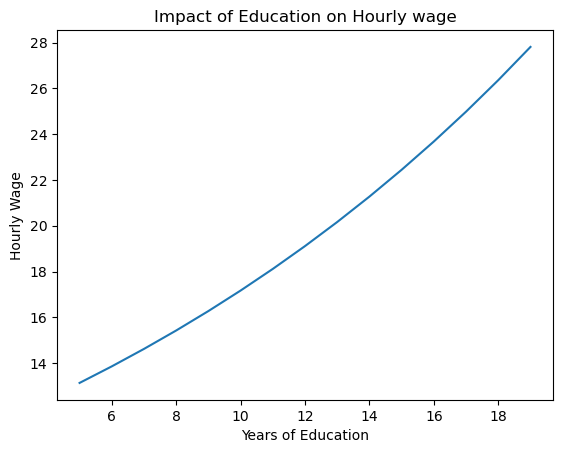

In [31]:
import matplotlib.pyplot as plt

plt.plot(
    np.array(range(5, 20)),
    np.exp(model_1.params['const'] + model_1.params['educ'] * np.array(range(5, 20)))
)
plt.xlabel('Years of Education')
plt.ylabel('Hourly Wage')
plt.title('Impact of Education on Hourly wage')
plt.show()

In [33]:
controls = ['IQ', 'exper', 'tenure', 'age', 'married', 'black',
            'south', 'urban', 'sibs', 'brthord', 'meduc', 'feduc']

X = wage[controls].assign(intercept = 1)
t = wage['educ']
y = wage['lhwage']

beta_aux = regress(t, X)
t_tilde = t - X.dot(beta_aux)

kappa = t_tilde.cov(y) / t_tilde.var()
print(f'Kappa: {kappa : .4f}')

Kappa:  0.0411
